In [1]:
import musclebeachtools_hlab as mbt
import neuraltoolkit as ntk
import eccojams as eco
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import numpy.linalg as la
import numpy.ma as ma
import sys
from datetime import date
import time
import glob, os
import pickle
import pandas as pd
import scipy
import scipy.cluster.hierarchy as spc
from statsmodels.sandbox.tsa.movstat import movmean
import json
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as clr

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Arial'})

today = date.today()
today = today.strftime("%Y_%m_%d")

basedir = os.path.dirname(os.path.dirname(os.getcwd()))
pth = basedir + '/notebooks/figure_1/'

from matplotlib.colors import LinearSegmentedColormap
clist = [(0.1, 0.6, 1.0), (0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
blue_orange_divergent = LinearSegmentedColormap.from_list("custom_blue_orange", clist)

In [2]:
#                        Colors

with open(f'{basedir}/colormaps/geno_colors.json') as json_file:
    geno_clrs = json.load(json_file)
    
with open(f'{basedir}/colormaps/reg_colors.json') as json_file:
    reg_clrs = json.load(json_file)

with open(f'{basedir}/colormaps/sleep_colors.json') as json_file:
    sleep_clrs = json.load(json_file)
    
ld_clrs = {
    'light': '#f9ffcf',
    'dark': '#5C5C5C'
}

sleep_nums = {
    1: 'active',
    2: 'NREM',
    3: 'REM',
    }

dump = 0

In [3]:
# Set up the time series of firing rates by region across 24h with sleep wake information

binsz = 1
reclen = 24 * 3600 * binsz

regions = ['ACAd','RSP','CA1','VISp']

# Load, bin, average across population, and normalize spiking data
spk1_file = f'{basedir}/data/CAF81/0304/0_12/CAF81_0304_0_12_singleunits.npy'
spk2_file = f'{basedir}/data/CAF81/0304/12_24/CAF81_0304_12-24_singleunits.npy'

spk1 = np.load(spk1_file,allow_pickle=True)
spk2 = np.load(spk2_file,allow_pickle=True)

rsurates = []
fsrates = []

reg_names ={
    'VISp': 'V1',
    'RSP': 'RSC',
    'ACAd': 'ACC',
    'CA1': 'CA1'
    }

for roi in regions:
    spk1_reg = eco.nrnlist_by_region(spk1,reg_names[roi])
    spk2_reg = eco.nrnlist_by_region(spk2,reg_names[roi])
    spk1_rsu = eco.nrnlist_by_celltype(spk1_reg,'RSU')
    spk2_rsu = eco.nrnlist_by_celltype(spk2_reg,'RSU')
    spk1_fs = eco.nrnlist_by_celltype(spk1_reg,'FS')
    spk2_fs = eco.nrnlist_by_celltype(spk2_reg,'FS')
    rsurates_1 = np.mean(eco.bin_spikes(spk1_rsu,binsize=binsz,starttime=0,endtime=(12*3600)),axis=0)
    rsurates_2 = np.mean(eco.bin_spikes(spk2_rsu,binsize=binsz,starttime=0,endtime=(12*3600)),axis=0)
    rsurates.append(np.hstack([eco.zscore_all(rsurates_1),eco.zscore_all(rsurates_2)]))
    fsrates_1 = np.mean(eco.bin_spikes(spk1_fs,binsize=binsz,starttime=0,endtime=(12*3600)),axis=0)
    fsrates_2 = np.mean(eco.bin_spikes(spk2_fs,binsize=binsz,starttime=0,endtime=(12*3600)),axis=0)
    fsrates.append(np.hstack([eco.zscore_all(fsrates_1),eco.zscore_all(fsrates_2)]))
    
# Load and concatenate sleep scores from two consecutive 12 hour blocks

sleepfiles = np.sort(glob.glob(f'{basedir}/data/CAF81/0304/*/*sleep.npy'))

sleepdf_b1 = eco.return_sleep_scores(sleepfiles[0])
sleepdf_b2 = eco.return_sleep_scores(sleepfiles[1])

sleepdf_b2.start_time = sleepdf_b2.start_time + sleepdf_b1.stop_time.iloc[-1]
sleepdf_b2.stop_time = sleepdf_b2.stop_time + sleepdf_b1.stop_time.iloc[-1]

sleepdf = pd.concat([sleepdf_b1,sleepdf_b2])

# Determine recording and video start times

with open(f'{basedir}/data/CAF81/0304/0_12/files.txt') as f:
    first_line = f.readline()
    recstart = first_line.split('int16_')[-1].split('.bin')[0]
recstart_dt = eco.dtify(recstart)

firstvid = np.sort(glob.glob(f'{basedir}/data/CAF81/0304/video/*.h5'))[0].split('/')[-1]
vidstart = eco.vidfile_to_datetime(firstvid)
vidstart_dt = eco.dtify(vidstart)

# Load and resample locomotion data

locofiles = np.sort(glob.glob(f'{basedir}/data/CAF81/0304/video/*tmove.npy'))

loco = np.array([])
for f in locofiles:
    loc = np.load(f)[0,:]
    fps = loc.shape[0]/3600
    loco_rs = np.mean(np.reshape(loc,[int(loc.shape[0]/int(fps * binsz)),int(fps * binsz)]),axis=1)
    loco = np.concatenate([loco,loco_rs])

/tmp/ipykernel_17875/3640291306.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  darktime_bins = np.int(darktime_sec/binsz)


slice(599, -1198, None)
slice(599, -1198, None)
slice(599, -1198, None)
slice(599, -1198, None)


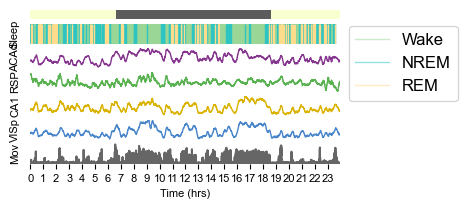

In [4]:
#Plotting step
fig,ax = plt.subplots(nrows=7,ncols=1,figsize=(4,2),
    gridspec_kw={'height_ratios': [1,2,2,2,2,2,2]},sharex=True)

#L/D Plotting
darktime = eco.dtify(recstart.split('_')[0] + '_19-30-00') #hard coded
darktime_sec = (darktime - recstart_dt).seconds
darktime_bins = np.int(darktime_sec/binsz)

category_names = ['Light', 'Dark', 'Light']
category_colors = np.array([ld_clrs['light'],ld_clrs['dark'],ld_clrs['light']])
lefts = np.array([0,darktime_bins, darktime_bins + (12*3600*binsz)])
widths = np.array([darktime_bins,(12*3600*binsz),reclen-(darktime_bins+(12*3600*binsz))])

ax[0].invert_yaxis()
ax[0].xaxis.set_visible(False)

for c, (colname, color) in enumerate(zip(category_names, category_colors)):
    ax[0].barh([''], widths[c], left=lefts[c], height=0.5,
                    label=colname, color=color)
ax[0].axis('off')
#ax[0].text(darktime_bins,1,'test')
#End L/D Plotting

for r,roi in enumerate(regions):
    frsma = movmean(rsurates[r][:reclen],windowsize=600)
    ax[r+2].plot(frsma, color = reg_clrs[reg_names[roi]],label='Simple Moving Average', lw = 1)
    ax[r+2].set_ylabel(f'{roi}',fontsize=8)

ax[6].plot(loco[:reclen],alpha=0.6,color='black')
ax[6].set_ylabel('Mov',fontsize=8)

#sleep plotting
sleepdf_reclen = sleepdf[sleepdf.stop_time<(reclen/binsz)]

for c, statename in enumerate(np.unique(sleepdf_reclen.sleepstate)):
    
    state = sleepdf_reclen[sleepdf_reclen.sleepstate==statename]
    
    for j in range(len(state)):
        
        ax[1].axvspan(xmin=state["start_time"].iloc[j], xmax=state["stop_time"].iloc[j],
                      color=sleep_clrs[sleep_nums[statename]], alpha=1)

custom_lines = [Line2D([0], [0], color=sleep_clrs['active'], alpha=0.5, lw=1),
            Line2D([0], [0], color=sleep_clrs['NREM'], alpha=0.5, lw=1),
            Line2D([0], [0], color=sleep_clrs['REM'], alpha=0.5, lw=1)]

ax[1].legend(custom_lines,['Wake','NREM','REM'],bbox_to_anchor=(1,1.3),fontsize=12)

ax[1].set_ylabel('Sleep',fontsize=8)

for i in np.arange(1,7):
    ax[i].set_yticks([])

for i in np.arange(1,6):
    ax[i].xaxis.set_visible(False)
    
for i in np.arange(1,7):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)

minbwtix = 60
xtix = np.arange(0,reclen,60*minbwtix/binsz)
xtixlabs = (xtix*binsz/3600).astype(int)

ax[6].set_xticks(xtix)
ax[6].set_xticklabels(xtixlabs,fontsize=8)
ax[6].set_xlabel('Time (hrs)',fontsize=8)

plt.xlim(0,reclen)

if dump:
    filename = '_longterm_recording_fig.pdf'
    plt.savefig(pth+today+filename, bbox_inches='tight')
else:
    pass

plt.show()

In [5]:
headdir = f'{basedir}/data/'

n_wt_all = np.load(headdir+'wt_mod.npy', allow_pickle=True)
n_app_all = np.load(headdir+'app_mod.npy', allow_pickle=True)

n_wt = eco.nrnlist_by_quality(n_wt_all,[1])
n_app = eco.nrnlist_by_quality(n_app_all,[1])

nrns = n_wt + n_app

In [6]:
colarray = np.tile(np.linspace(0,1,10),np.ceil(len(nrns)/10).astype('int'))[:len(nrns)]
col = plt.cm.viridis(colarray)

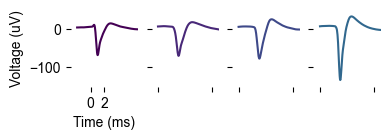

In [7]:
xtickpos = np.array([50,100])
xticklabs = (xtickpos/25000 * 1e3).astype(int) - 2

usethese = [18, 314, 316, 325]

nrns2 = [nrns[i] for i in usethese]

fign, axn = plt.subplots(ncols = 4, nrows = 1, figsize = [4,1])

for i,n in enumerate(nrns2):
    
    wfdat = n.waveforms
    axn[i].plot(wfdat,c=col[i])
    axn[i].set_ylim(-150,50)
    
    midpt = np.argmin(wfdat)
    axn[i].set_xlim(midpt-100,midpt+150)
    
    if i == 0:
        axn[i].set_xticks(xtickpos)
        axn[i].set_xticklabels(xticklabs)

        axn[i].set_ylabel('Voltage (uV)')
        axn[i].set_xlabel('Time (ms)')
    else:

        axn[i].set_xticklabels('')
        axn[i].set_yticklabels('')
        axn[i].set_ylabel('')
        axn[i].set_xlabel('')
        

sns.despine(left = True, bottom = True)

if dump:
    plt.savefig(pth+today+'_meanWFs_'+'.pdf')
else:
    pass

#     plt.show()

In [8]:
nrnlist = np.array(list(n_wt_all) + list(n_app_all))
goodcells = [92, 430, 504, 544, 632]

n_lines = len(goodcells)
col = np.arange(1, n_lines + 1)

norm = mpl.colors.Normalize(vmin=col.min(), vmax=col.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

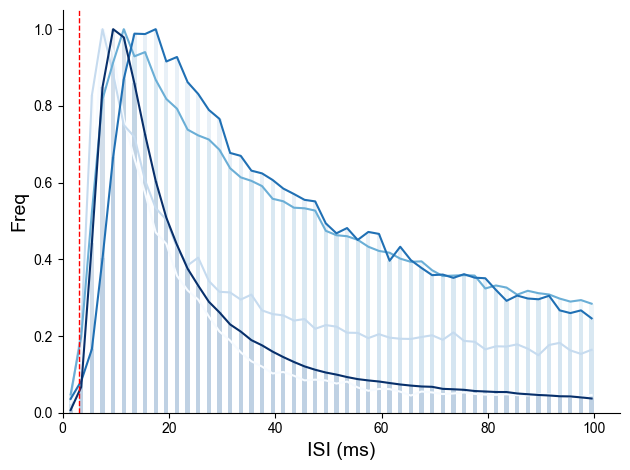

In [9]:
# '#5DADE2'

for i,c in enumerate(goodcells):
# i = 544
    cell = nrnlist[c]
    time_s = cell.spike_time/cell.fs
    start = cell.start_time
    end = cell.end_time
    idx = np.where(np.logical_and(time_s >= start, time_s <= end))[0]
    ISI = np.diff(time_s[idx])
    edges = np.linspace(0, 0.1, 51)
    hist_isi = np.histogram(ISI, edges)
    plt.bar(edges[1:]*1000-0.5, hist_isi[0]/np.max(hist_isi[0]), color= cmap.to_rgba(i + 1),alpha=0.1)
    plt.plot(edges[1:]*1000-0.5, hist_isi[0]/np.max(hist_isi[0]), color= cmap.to_rgba(i + 1))
#     plt.bar(edges[1:]*1000-0.5, hist_isi[0], color= cmap.to_rgba(i + 1),alpha=0.2)
#     plt.plot(edges[1:]*1000-0.5, hist_isi[0], color= cmap.to_rgba(i + 1))

plt.axvline(x=3, color='r', linestyle='dashed', linewidth=1) #dashed line at 3 ms
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.xlabel('ISI (ms)',fontsize=14)
plt.ylabel('Freq',fontsize=14)

plt.tight_layout()
sns.despine()

if dump:
    filename = f'ISIs_representative.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass

plt.show()

In [10]:
epochstatscsv = f'{basedir}/data/epoch_stats_100ms.csv'

epochstats = pd.read_csv(epochstatscsv)
epochstats['sleepoch'] = ['_'.join(i) for i in zip(epochstats['date'].astype(str), epochstats['recepoch'].astype(str), epochstats['epoch'].astype(str))]

epochagg = epochstats[['geno','state','sleepoch','animal','epoch_len']].groupby(['geno','state','sleepoch']).max().reset_index()
epochagg = epochagg.sort_values(['geno','state'], ascending = [False,True])

ind = np.unique(epochagg.animal, return_index=True)[1]
animallist = [epochagg.animal.iloc[i] for i in sorted(ind)]

time_in_state = np.zeros([8,3])
for a, animal in enumerate(animallist):
    for s,state in enumerate(['active','nrem','rem']):
        time_in_state[a,s] = np.sum(epochagg[(epochagg.animal==animal)&(epochagg.state==state)].epoch_len)
        
time_in_state_mean_wt = np.mean(time_in_state[:4,:],axis=0)
time_in_state_mean_app = np.mean(time_in_state[4:,:],axis=0)

perc_in_state = (time_in_state.T/np.sum(time_in_state,axis=1)).T
perc_in_state_mean_wt = np.mean(perc_in_state[:4,:],axis=0)
perc_in_state_mean_app = np.mean(perc_in_state[4:,:],axis=0)

epochstats['adr_id'] = epochstats['animal'] + '_' + epochstats['date'].astype(str) + '_' + epochstats['recepoch']

selected_recepochs = ['CAF69_1230_12_24', 'CAF71_103_0_12', 'CAF73_120_4_15', 'CAF74_125_48_60',
'CAF75_125_53_64', 'CAF77_202_12_24', 'CAF81_304_12_24', 'CAF82_304_12_24']

epochstats_1rec = epochstats[epochstats.adr_id.isin(selected_recepochs)]
epoch_meanfr = epochstats_1rec[['epoch','fr_mean','state','geno','region']]
epoch_meanfr['cell'] = epochstats_1rec['animal'] + '_' + epochstats_1rec['region'] + '_' + epochstats_1rec['nrnind'].astype('str')
epoch_meanfr['recdate'] = epochstats_1rec['date'].astype('str') + '_' + epochstats_1rec['recepoch']
epoch_meanfr_agg = epoch_meanfr.groupby(['cell','recdate','state','geno','region'],as_index=False).mean()
epoch_meanfr_agg = epoch_meanfr_agg.drop('epoch',axis=1)
epoch_meanfr_agg['n_epoch'] = epoch_meanfr.groupby(['cell','recdate','state','geno','region'],as_index=False).count()['epoch']


/tmp/ipykernel_17875/2813084234.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epoch_meanfr['cell'] = epochstats_1rec['animal'] + '_' + epochstats_1rec['region'] + '_' + epochstats_1rec['nrnind'].astype('str')
/tmp/ipykernel_17875/2813084234.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epoch_meanfr['recdate'] = epochstats_1rec['date'].astype('str') + '_' + epochstats_1rec['recepoch']


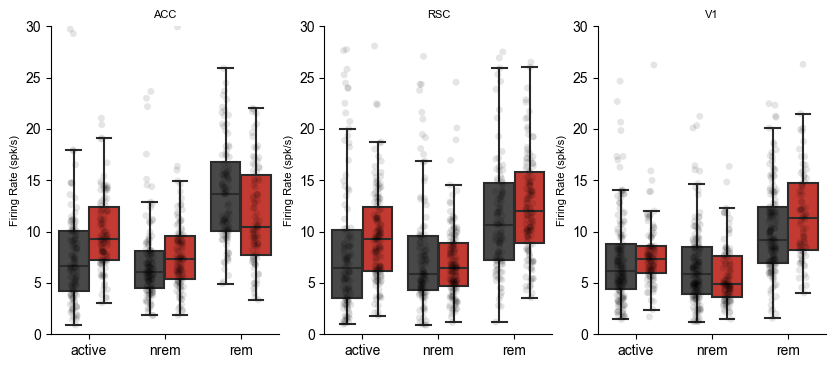

In [11]:
figf, axf = plt.subplots(ncols = 3, nrows = 1, figsize = [10,4])

regions = np.unique(epoch_meanfr_agg.region)

for i, roi in enumerate(regions):
    sns.boxplot( x='state', y='fr_mean', hue='geno', data = epoch_meanfr_agg[epoch_meanfr_agg.region==roi],
                   palette = [geno_clrs['WT'],geno_clrs['APP']], fliersize=0, ax = axf[i])
    
    sns.stripplot( x='state', y='fr_mean', hue='geno', data=epoch_meanfr_agg[epoch_meanfr_agg.region==roi],
               palette = ['black', 'black'], dodge=True, alpha = 0.1, ax = axf[i], edgecolor = ['white','white'])
    
    axf[i].set_title(str(roi).upper(),fontsize=8)
    axf[i].set_ylabel('Firing Rate (spk/s)',fontsize=8)
    axf[i].set_xlabel('')

    axf[i].set_ylim(0,30)
    sns.despine()
    axf[i].legend([],[], frameon=False)
    
if dump:
    filename = f'_meanfr_by_state_boxplot.pdf'
    plt.savefig(pth+today+filename)
else:
    pass
plt.show()